Importing libraries

In [9]:
from preprocess import load_all_data, preprocess_coffee_data, build_features
from evaluation import get_user_relevance, calculate_ndcg
from recommender import recommend, recommend_popular
import lightgbm as lgb
import numpy as np
import pandas as pd
import joblib
import os

Data loading

In [10]:
# Load all datasets required for training and validation
recipes_raw, users_raw, train_raw, val_warm_raw, val_cold_raw = load_all_data()

Preprocessing and feature engineering

In [11]:
# Transform raw data and generate the interaction matrix
recipes, users, train = preprocess_coffee_data(recipes_raw, users_raw, train_raw)
train_matrix = build_features(train, recipes, users)

Feature selection

In [12]:
# Select relevant numerical features for the ranking model
numeric_features = [
    'taste_bitterness', 'taste_sweetness', 'taste_acidity', 'taste_body', 'strength_norm',
    'taste_pref_bitterness', 'taste_pref_sweetness', 'taste_pref_acidity', 'taste_pref_body', 'pref_strength_norm',
    'delta_bitterness', 'delta_sweetness', 'delta_acidity', 'delta_body', 'strength_match'
]

X_train = train_matrix[numeric_features]
y_train = train_matrix['rating']

Model training

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# --- Configuration ---
RATING_THRESHOLD = 3.2
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Hyperparameters optimized to reduce overfitting (reduced complexity)
LGBM_PARAMS = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,         # Reduced from 127
    'max_depth': 7,           # Restricted depth
    'n_estimators': 2000,
    'min_child_samples': 50,  # Increased for stability
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

# 1. Target Variable Preparation
# Convert continuous ratings to binary target (1 if Like, 0 if Dislike)
y = (train_matrix['rating'] >= RATING_THRESHOLD).astype(int)
X = train_matrix[numeric_features]

# 2. Dynamic Class Weight Calculation
# Automatically adjust for imbalance between positive and negative classes
pos_count = y.sum()
neg_count = len(y) - pos_count
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

print(f"Class Balance - Positive: {pos_count}, Negative: {neg_count}")
print(f"Calculated scale_pos_weight: {scale_pos_weight:.4f}")

# 3. Validation Split
# Stratified split ensures consistent class distribution in Train/Validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)

# 4. Model Initialization
# Inject the calculated weight into the parameters
model = lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight, **LGBM_PARAMS)

# 5. Training with Early Stopping
# Stops training if 'valid' metric doesn't improve for 50 rounds
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

print("\n--- Starting Training ---")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=['Train', 'Valid'],
    callbacks=callbacks
)

# 6. Evaluation Metrics
print("\n--- Validation Performance ---")
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_val, y_prob):.4f}")

Positive: 22243, Negative: 23291, Calculated scale_pos_weight: 1.0471
[LightGBM] [Info] Number of positive: 17794, number of negative: 18633
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 36427, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488484 -> initscore=-0.046073
[LightGBM] [Info] Start training from score -0.046073
Training until validation scores don't improve for 50 rounds
[100]	Train's auc: 0.796382	Valid's auc: 0.763978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

Model serialization

In [17]:
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(model, 'models/coffee_model.pkl')
print("Model successfully saved to models/coffee_model.pkl")

Model successfully saved to models/coffee_model.pkl


Performance Evaluation (NDCG@5)

In [18]:
test_users = val_warm_raw['user_id'].unique()[:50] 
scores_pop = []
scores_ml = []

for u_id in test_users:
    # 1. Prepare ground truth ratings
    user_test_data = val_warm_raw[val_warm_raw['user_id'] == u_id]
    true_ratings = dict(zip(user_test_data['recipe_id'], user_test_data['rating']))

    # 2. Evaluate Popularity Baseline
    # recommend_popular returns a list of tuples, so [recipe[0]...] is correct here
    pop_recs = recommend_popular(u_id, users, recipes, train)
    pop_ids = [recipe[0] for recipe in pop_recs]
    scores_pop.append(calculate_ndcg(true_ratings, pop_ids, n=5))

    # 3. Evaluate Hybrid ML Model
    # recommend() now returns a list of DICTIONARIES for the API/Frontend
    ml_recs = recommend(u_id, users, recipes, train, strategy="hybrid_ml")
    
    # CHANGE THIS LINE: access the dictionary key 'recipe_id' instead of index [0]
    ml_ids = [recipe['recipe_id'] for recipe in ml_recs]
    
    scores_ml.append(calculate_ndcg(true_ratings, ml_ids, n=5))

print(f"\nEvaluation Results (Mean NDCG@5):")
print(f"Popularity Baseline: {np.mean(scores_pop):.4f}")
print(f"Hybrid ML Model:     {np.mean(scores_ml):.4f}")


Evaluation Results (Mean NDCG@5):
Popularity Baseline: 0.4192
Hybrid ML Model:     0.3983


Result visualization

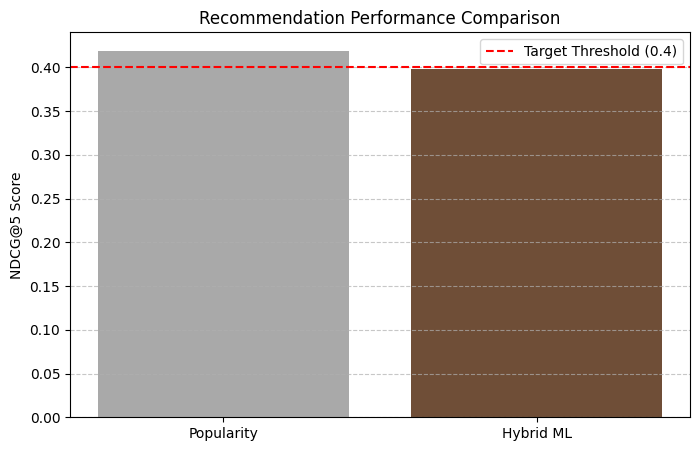

In [16]:
import matplotlib.pyplot as plt

# Visualize performance comparison for the pitch presentation
methods = ['Popularity', 'Hybrid ML']
values = [np.mean(scores_pop), np.mean(scores_ml)]

plt.figure(figsize=(8, 5))
plt.bar(methods, values, color=['#A9A9A9', '#6F4E37'])
plt.ylabel('NDCG@5 Score')
plt.title('Recommendation Performance Comparison')
plt.axhline(y=0.4, color='red', linestyle='--', label='Target Threshold (0.4)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()